In [1]:
import scipy.stats as st

import autograd.numpy as np
from autograd import grad
from autograd.scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

In [2]:

def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    # autograd magic
    dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in tqdm_notebook(momentum.rvs(size=size)):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])


def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p


In [3]:
negative_log_prob = lambda x: -np.log(multivariate_normal.pdf(x, [1, 9], [[1., .8], [.8, 1.]]))
n_samples = 10000
initial_position = np.array([0.,0.])

samples = hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5)


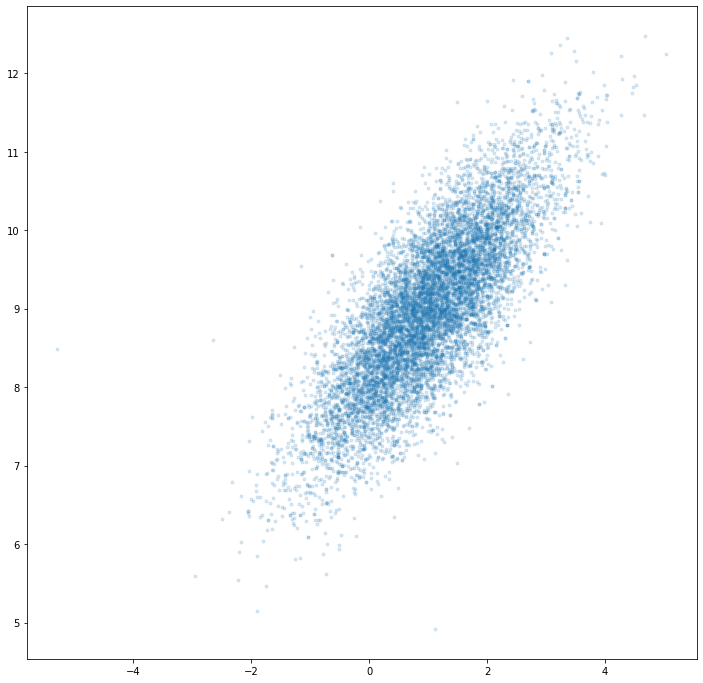

In [6]:
plt.figure(figsize=(12,12))
plt.plot(samples[:, 0], samples[:, 1], linestyle='', marker='o', markersize=3, alpha=0.15);

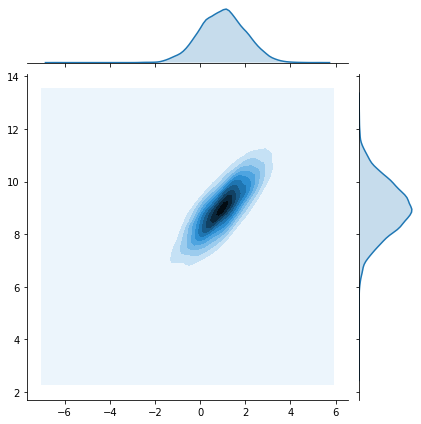

In [5]:
import seaborn as sns
sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')